## Principal Component Analysis - Dimensionality reduction

```{admonition} What is dimensionality reduction?
Dimensionality reduction is the process of transforming high-dimensional data into a lower-dimensional space while preserving the most important features or patterns. In the context of single-cell RNA sequencing (scRNA-seq), where each cell is represented by thousands of gene expression values, dimensionality reduction is crucial for simplifying the data, reducing noise, and enabling meaningful visualization and analysis.
```

### Using PCA

- The first few PCs (e.g., PC1, PC2, PC3) explain the largest proportion of variance, with a steep drop-off in variance explained as the ranking increases.
- After approximately the 10th PC, the variance explained by each additional PC becomes minimal, indicating diminishing returns in terms of information captured.

c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\scanpy\preprocessing\_pca.py:377: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


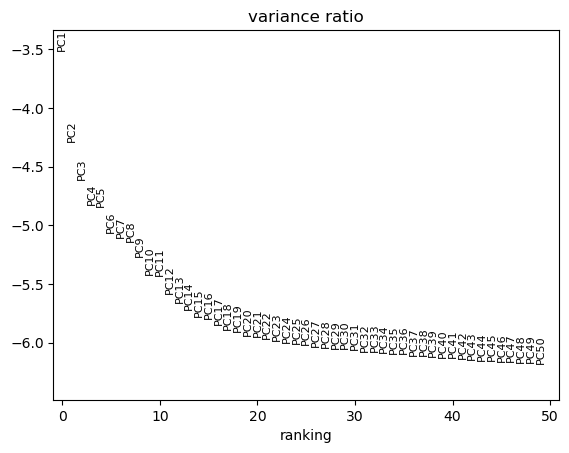

In [ ]:
# Run PCA (using ARPACK for reproducibility)
sc.tl.pca(adata_filtered, 
          n_comps=64, 
          svd_solver='arpack',  # Best for reproducibility
          use_highly_variable=True)  # Use the 2000 HVGs

# Plot variance explained
sc.pl.pca_variance_ratio(adata_filtered, n_pcs=64, log=True)

In [80]:
np.cumsum(adata_filtered.uns['pca']['variance_ratio'])

array([0.02982847, 0.04353569, 0.0534675 , 0.06150168, 0.06939694,
       0.07571189, 0.08177835, 0.08763348, 0.09276243, 0.097189  ,
       0.10155126, 0.10531369, 0.10880657, 0.11208757, 0.11517075,
       0.11819483, 0.12108765, 0.12385833, 0.12657326, 0.12920351,
       0.13181002, 0.13437727, 0.13689186, 0.1393744 , 0.14182699,
       0.14426738, 0.14666459, 0.14902763, 0.15138672, 0.15372702,
       0.15605642, 0.15835232, 0.16064428, 0.16291155, 0.16516817,
       0.16741067, 0.16963257, 0.1718447 , 0.17403933, 0.17621431,
       0.17838238, 0.1805329 , 0.18266787, 0.18479817, 0.18692064,
       0.18902254, 0.19111815, 0.1932109 , 0.19529845, 0.19737189],
      dtype=float32)

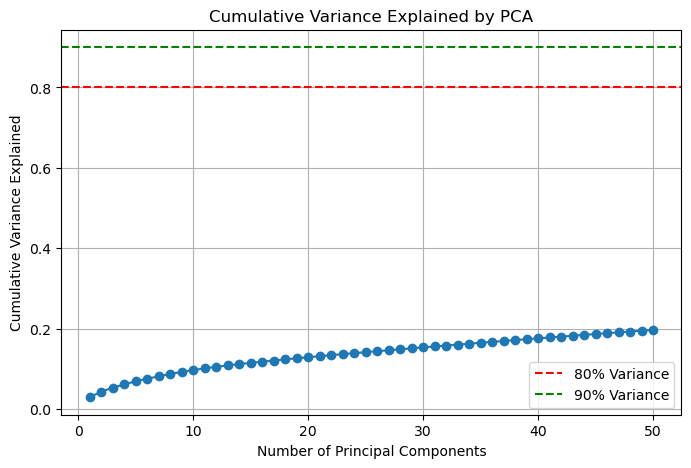

In [81]:
cumulative_variance = np.cumsum(adata_filtered.uns['pca']['variance_ratio'])

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-')

# Labels and title
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by PCA')
plt.axhline(y=0.8, color='r', linestyle='--', label='80% Variance')  # Mark 80% threshold
plt.axhline(y=0.9, color='g', linestyle='--', label='90% Variance')  # Mark 90% threshold
plt.legend()
plt.grid()

# Show plot
plt.show()

#### Caclulate performance metrics

In [82]:
# Helper: get embedding from AnnData
def get_embedding(adata, key):
    if key == 'X_pca':
        return adata.obsm['X_pca']
    elif key == 'X_harmony':
        return adata.obsm['X_harmony']
    else:
        raise ValueError("Unknown embedding key")

In [ ]:
# calculate batch entropy mixing
def batch_entropy(adata, embedding_key, batch_key, n_neighbors=30):
    from sklearn.neighbors import NearestNeighbors
    X = adata.obsm[embedding_key]
    batches = adata.obs[batch_key].values
    le = LabelEncoder()
    batch_labels = le.fit_transform(batches)
    nbrs = NearestNeighbors(n_neighbors=n_neighbors+1).fit(X)
    _, indices = nbrs.kneighbors(X)
    entropies = []
    for i, neighbors in enumerate(indices):
        neighbor_batches = batch_labels[neighbors[1:]]  # exclude self
        probs = np.bincount(neighbor_batches, minlength=len(le.classes_)) / n_neighbors
        entropy = -np.sum([p * np.log2(p) for p in probs if p > 0])
        entropies.append(entropy)
    return np.mean(entropies)

In [84]:
# Calculate metrics for PCA
pca_embedding = get_embedding(adata_filtered, 'X_pca')
cell_types = adata_filtered.obs['cell_type'].values
batches = adata_filtered.obs['plate_id'].values

silhouette_pca = silhouette_score(pca_embedding, cell_types)
batch_entropy_pca = batch_entropy(adata_filtered, 'X_pca', 'plate_id')

In [85]:
# Calculate metrics for Harmony
harmony_embedding = get_embedding(adata_filtered, 'X_harmony')
silhouette_harmony = silhouette_score(harmony_embedding, cell_types)
batch_entropy_harmony = batch_entropy(adata_filtered, 'X_harmony', 'plate_id')

In [ ]:
# calculate ARI and NMI
def clustering_metrics(embedding, true_labels, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(embedding)
    pred_labels = kmeans.labels_
    ari = adjusted_rand_score(true_labels, pred_labels)
    nmi = normalized_mutual_info_score(true_labels, pred_labels)
    return ari, nmi

In [ ]:
# variance explained (for PCA)
def variance_explained(adata):
    if 'pca' in adata.uns and 'variance_ratio' in adata.uns['pca']:
        return np.sum(adata.uns['pca']['variance_ratio'])
    else:
        return np.nan

In [88]:
results = pd.DataFrame({
    'Method': ['PCA', 'Harmony'],
    'Silhouette Score (cell type)': [silhouette_pca, silhouette_harmony],
    'Batch Entropy Mixing': [batch_entropy_pca, batch_entropy_harmony]
})

In [89]:
methods = {
    'PCA': 'X_pca',
    'Harmony': 'X_harmony',
}

In [90]:
results = []

# Encode cell types for metrics
cell_types = LabelEncoder().fit_transform(adata_filtered.obs['cell_type'])
n_cell_types = len(np.unique(cell_types))

In [91]:
for method, emb_key in methods.items():
    embedding = get_embedding(adata_filtered, emb_key)
    # Silhouette Score
    silhouette = silhouette_score(embedding, cell_types)
    # Batch Entropy
    batch_entropy_val = batch_entropy(adata_filtered, emb_key, 'plate_id')
    # ARI & NMI (using KMeans, number of clusters = number of cell types)
    ari, nmi = clustering_metrics(embedding, cell_types, n_cell_types)
    # Variance explained (only for PCA)
    var_exp = variance_explained(adata_filtered) if method == 'PCA' else np.nan
    # Append to results
    results.append({
        'Method': method,
        'Silhouette Score (cell type)': silhouette,
        'Batch Entropy Mixing': batch_entropy_val,
        'ARI': ari,
        'NMI': nmi,
        'Variance Explained': var_exp
    })

c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\henry\miniconda3\envs\dl_venv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [92]:
results_df = pd.DataFrame(results)
results_df

,Method,Silhouette Score (cell type),Batch Entropy Mixing,ARI,NMI,Variance Explained
0,PCA,0.189582,2.895963,0.537578,0.649484,0.197372
1,Harmony,0.218689,3.488787,0.550414,0.674881,NaN


**Selecting the best numbers of neighbors**

In [93]:
for k in [10, 15, 20, 30]:
    sc.pp.neighbors(adata_filtered, n_pcs=30, n_neighbors=k)
    sc.tl.leiden(adata_filtered, resolution=0.6, key_added=f'clust_k{k}')
    
    # Calculate silhouette score
    from sklearn.metrics import silhouette_score
    score = silhouette_score(adata_filtered.obsm['X_pca'][:,:30], 
                            adata_filtered.obs[f'clust_k{k}'])
    print(f"k={k}: Silhouette = {score:.3f}")

C:\Users\henry\AppData\Local\Temp\ipykernel_31552\1217238346.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_filtered, resolution=0.6, key_added=f'clust_k{k}')


k=10: Silhouette = 0.191
k=15: Silhouette = 0.182
k=20: Silhouette = 0.180
k=30: Silhouette = 0.160


#### Neighbourhood Graph and Umap

```{admonition} What is UMAP?
UMAP (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique commonly used in single-cell RNA sequencing (scRNA-seq) analysis. It reduces high-dimensional data (like thousands of gene expression values per cell) into a 2D or 3D representation while preserving the local structure of the data. This allows us to visualize relationships between cells in a lower-dimensional space.
```

In [94]:
# Build graph with optimal k=10
sc.pp.neighbors(
    adata_filtered,
    n_pcs=30,       # From variance plot
    n_neighbors=10,  # From silhouette
    metric='euclidean'
)

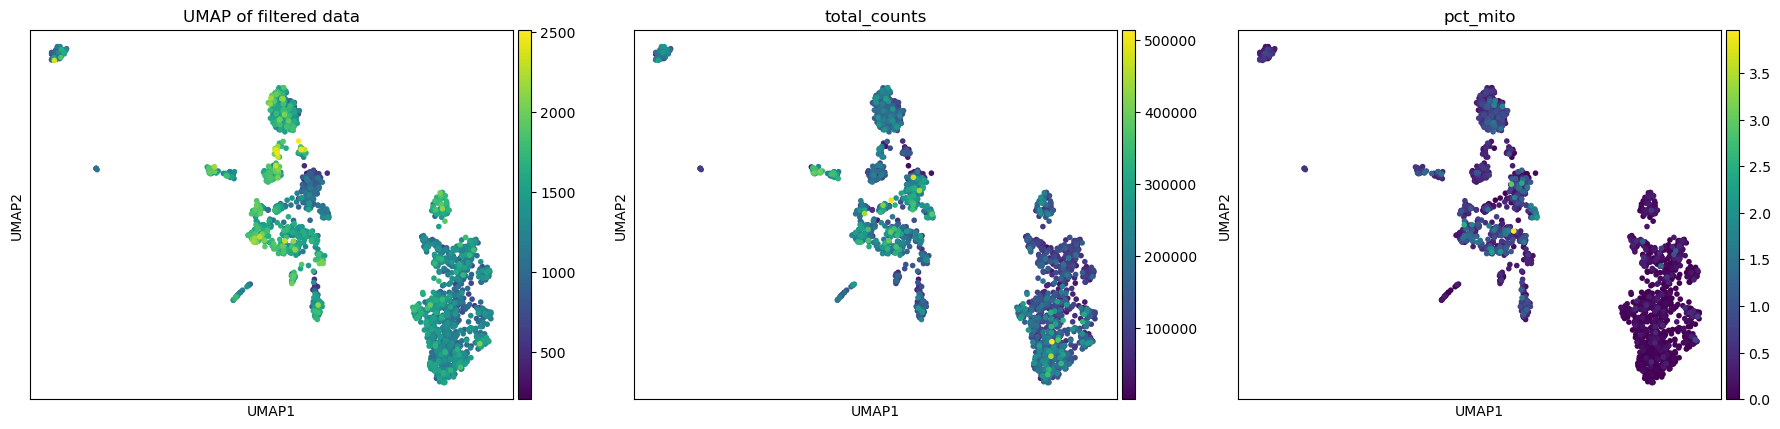

In [95]:
sc.pl.umap(adata_filtered, color=["n_genes_by_counts", "total_counts", "pct_mito"], ncols=3, title="UMAP of filtered data")

```{admonition} What is granularity in clusters?
In clustering algorithms like **Leiden** and **Louvain**, the **resolution parameter** controls the granularity of the clusters. It determines how finely or coarsely the data is partitioned into clusters. A higher resolution results in more, smaller clusters, while a lower resolution produces fewer, larger clusters.
```

### Clustering techniques

#### Using Leidein

The resolution parameter in Leiden clustering controls how granular your clusters will be:

- 0.4	Fewer, broader clusters	Identifying major cell types
- 0.6	Moderate clustering (default)	Balancing specificity/size
- 0.8	More, finer clusters	Detecting rare subtypes

In [96]:
# Cluster at multiple resolutions
for res in [0.4, 0.6, 0.8]:
    sc.tl.leiden(
        adata_filtered,
        resolution=res,
        key_added=f'leiden_r{res}'
    )

In [97]:
  
# Get cluster counts for each resolution
cluster_counts_r06 = adata_filtered.obs['leiden_r0.4'].value_counts().sort_index(ascending=True)
cluster_counts_r04 = adata_filtered.obs['leiden_r0.6'].value_counts().sort_index(ascending=True)
cluster_counts_r08 = adata_filtered.obs['leiden_r0.8'].value_counts().sort_index(ascending=True)


# Create a DataFrame
df_clusters = pd.DataFrame({
    'Leiden (r=0.4)': cluster_counts_r04,
    'Leiden (r=0.6)': cluster_counts_r06,
    'Leiden (r=0.8)': cluster_counts_r08
}).fillna(0).astype(int)  # Fill missing values with 0 and convert to integer

# Display table
print(df_clusters)

    Leiden (r=0.4)  Leiden (r=0.6)  Leiden (r=0.8)
0              315             324             237
1              296             323             223
10              42              11              56
11              22               5              47
12              11               0              42
13               5               0              27
14               0               0              22
15               0               0              11
16               0               0               5
2              238             315             220
3              223             259             215
4              220             220             186
5              191             190             165
6               76              56             136
7               72              56              99
8               56              42              76
9               56              22              56


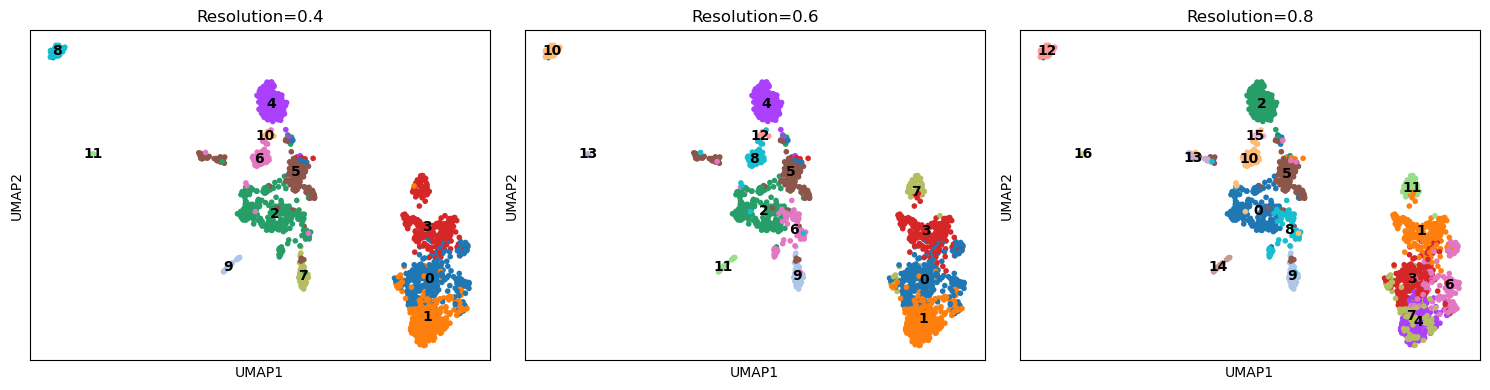

In [98]:
# Create a 3-panel plot comparing resolutions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, res in zip(axes, [0.4, 0.6, 0.8]):
    sc.pl.umap(
        adata_filtered,
        color=f'leiden_r{res}',
        title=f'Resolution={res}',
        ax=ax,
        legend_loc='on data',
        show=False
    )
plt.tight_layout()
plt.show()

```{admonition} What is silhoutte score?
The **silhouette score** is a metric used to evaluate the quality of clustering. It measures how similar a cell is to other cells in its own cluster compared to cells in other clusters. The score ranges from -1 to 1:
- A score close to **1** indicates that cells are well-matched to their own cluster and poorly matched to other clusters (good clustering).
- A score close to **0** indicates that cells are on the boundary between clusters.
- A score close to **-1** indicates that cells may be assigned to the wrong cluster.
```

The Leiden clustering results show that **resolution 0.6** provides the best-defined clusters based on the silhouette score. Lower resolutions (e.g., 0.4) result in broader clusters, while higher resolutions (e.g., 0.8) lead to finer granularity but less well-defined clusters.

In [99]:
from sklearn.metrics import silhouette_score

for res in [0.4, 0.6, 0.8]:
    score = silhouette_score(
        adata_filtered.obsm['X_pca'][:,:30], 
        adata_filtered.obs[f'leiden_r{res}']
    )
    print(f"Resolution {res}: Silhouette = {score:.3f}")

Resolution 0.4: Silhouette = 0.177
Resolution 0.6: Silhouette = 0.191
Resolution 0.8: Silhouette = 0.159


#### Clustering with louvain

In [100]:
for res in [0.4, 0.6, 0.8]:
    sc.tl.louvain(
        adata_filtered,
        resolution=res,
        key_added=f'louvain_r{res}',
        random_state=42
    )

In [101]:
# Get cluster counts for each resolution
louvain_counts_r04 = adata_filtered.obs['louvain_r0.4'].value_counts().sort_index(ascending=True)
louvain_counts_r06 = adata_filtered.obs['louvain_r0.6'].value_counts().sort_index(ascending=True)
louvain_counts_r08 = adata_filtered.obs['louvain_r0.8'].value_counts().sort_index(ascending=True)

# Create a DataFrame
df_louvain = pd.DataFrame({
    'Louvain (r=0.4)': louvain_counts_r04,
    'Louvain (r=0.6)': louvain_counts_r06,
    'Louvain (r=0.8)': louvain_counts_r08
}).fillna(0).astype(int)  # Fill missing values with 0 and convert to integer

# Display table
print(df_louvain)

    Louvain (r=0.4)  Louvain (r=0.6)  Louvain (r=0.8)
0               348              350              350
1               285              320              291
10                0               23               42
11                0               11               23
12                0                0               11
2               270              268              230
3               241              235              223
4               220              220              220
5               215              192              192
6               135               56               79
7                67               56               56
8                42               50               56
9                 0               42               50


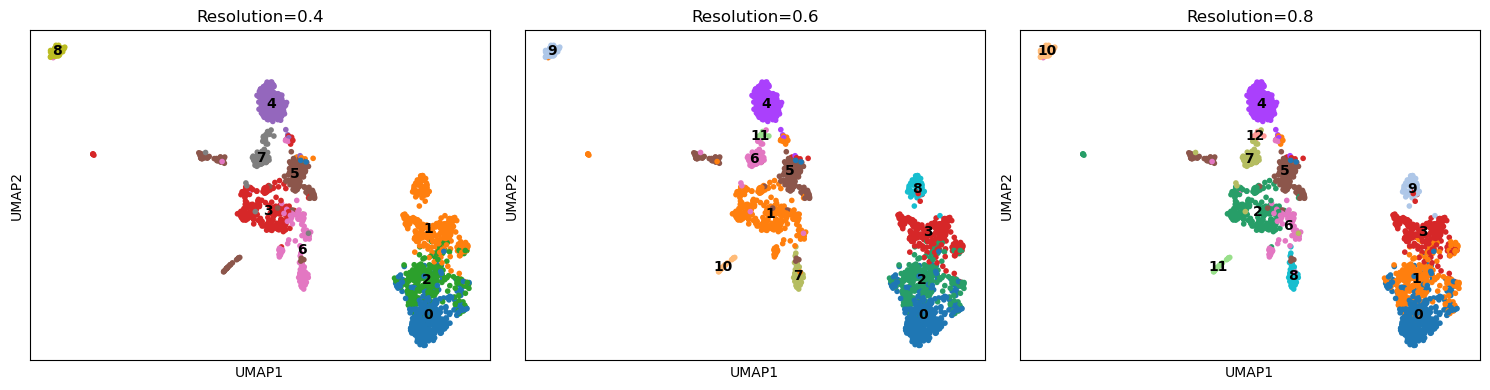

In [102]:
# Create a 3-panel plot comparing resolutions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for ax, res in zip(axes, [0.4, 0.6, 0.8]):
    sc.pl.umap(
        adata_filtered,
        color=f'louvain_r{res}',
        title=f'Resolution={res}',
        ax=ax,
        legend_loc='on data',
        show=False
    )
plt.tight_layout()
plt.show()

The Louvain clustering results show that higher resolutions lead to more clusters with smaller sizes, similar to the Leiden algorithm. However, Louvain tends to produce fewer, larger clusters compared to Leiden. The silhouette scores indicate that the clusters become more well-defined at higher resolutions, with the best score observed at **resolution 0.8**.

In [103]:
for res in [0.4, 0.6, 0.8]:
    score = silhouette_score(
        adata_filtered.obsm['X_pca'][:,:30], 
        adata_filtered.obs[f'louvain_r{res}']
    )
    print(f"Resolution {res}: Silhouette = {score:.3f}")

Resolution 0.4: Silhouette = 0.157
Resolution 0.6: Silhouette = 0.176
Resolution 0.8: Silhouette = 0.197


#### Comparation between clusters

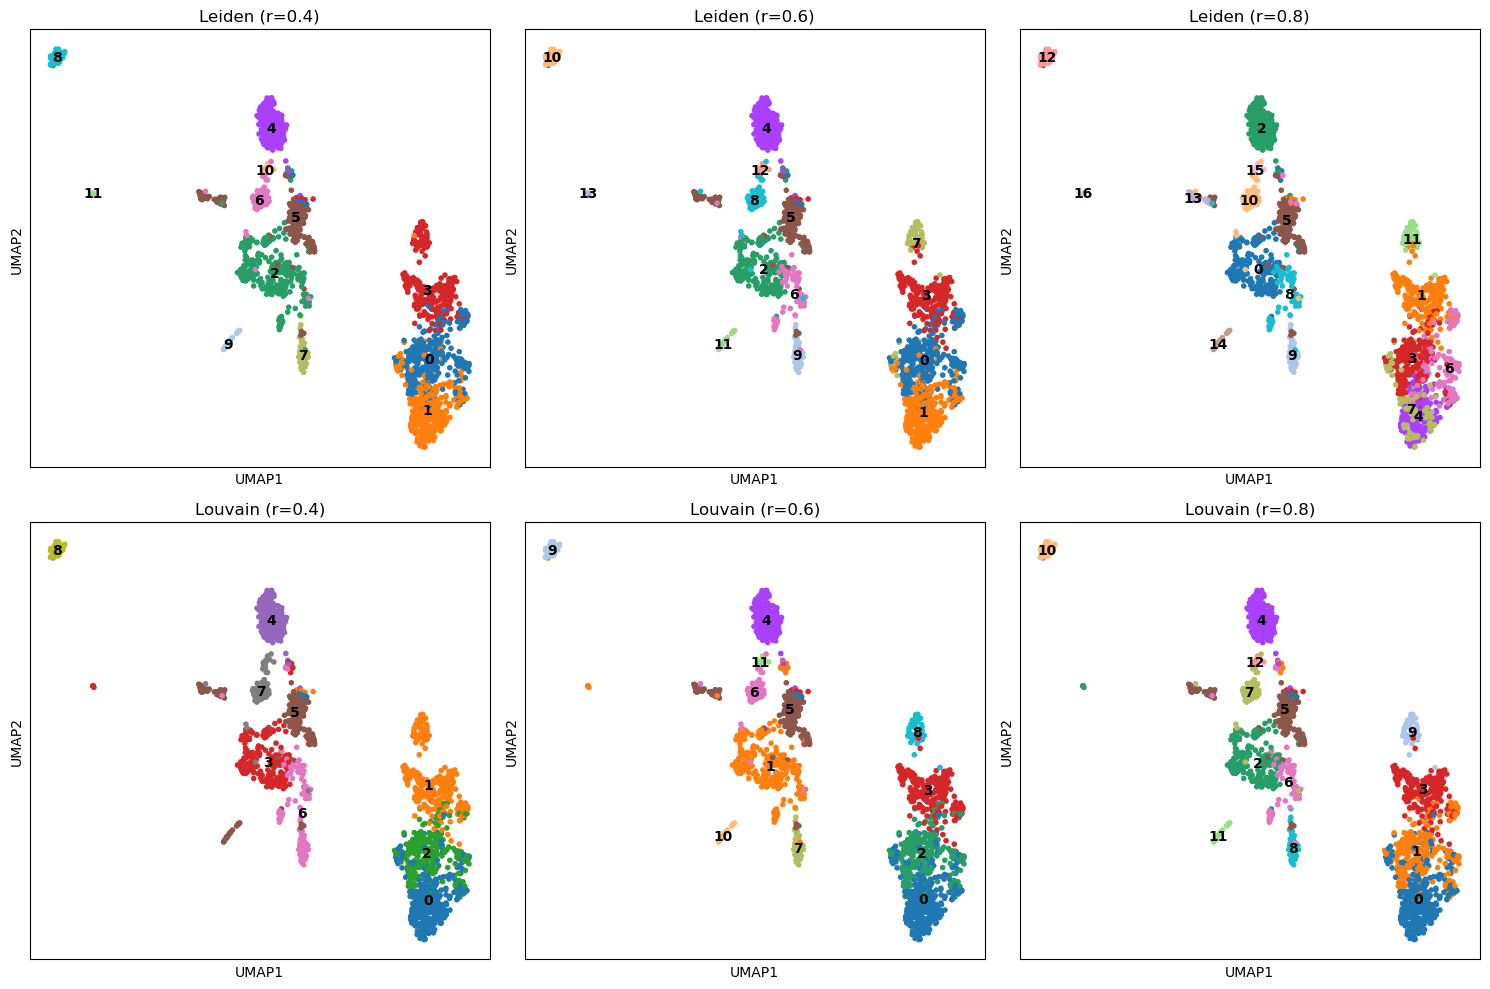

In [104]:
import matplotlib.pyplot as plt

# Create comparison plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Leiden results
for i, res in enumerate([0.4, 0.6, 0.8]):
    sc.pl.umap(
        adata_filtered,
        color=f'leiden_r{res}',
        title=f'Leiden (r={res})',
        ax=axes[0,i],
        legend_loc='on data',
        show=False
    )

# Louvain results
for i, res in enumerate([0.4, 0.6, 0.8]):
    sc.pl.umap(
        adata_filtered,
        color=f'louvain_r{res}',
        title=f'Louvain (r={res})',
        ax=axes[1,i],
        legend_loc='on data',
        show=False
    )

plt.tight_layout()
plt.show()

**Cluster size comparison**
 Leiden clustering (blue) generally produces a larger number of smaller clusters compared to Louvain (orange), which results in slightly larger clusters. As the resolution increases, both methods detect more fine-grained structures, but Leiden retains a greater diversity in cluster sizes. This suggests that Leiden might be more sensitive to capturing smaller subpopulations, while Louvain tends to favor more balanced partitions.

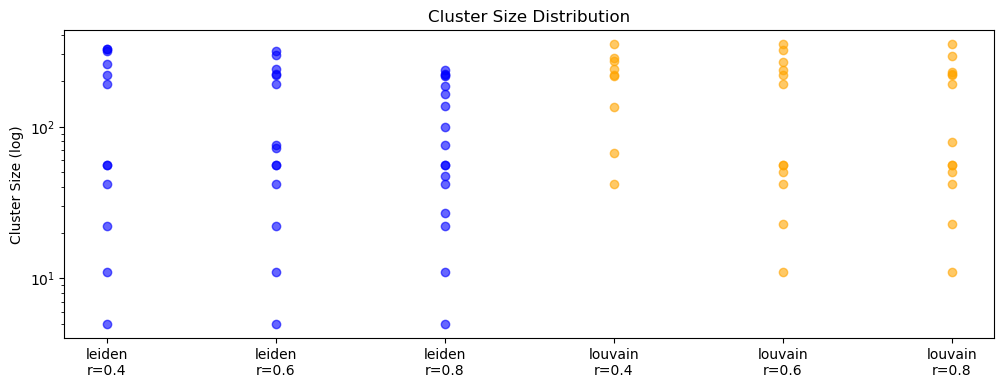

In [105]:
# Plot cluster sizes
plt.figure(figsize=(12, 4))
for i, method in enumerate(['leiden', 'louvain']):
    for res in [0.4, 0.6, 0.8]:
        counts = adata_filtered.obs[f'{method}_r{res}'].value_counts()
        plt.scatter(
            [f'{method}\nr={res}'] * len(counts),
            counts,
            color=['blue', 'orange'][i],
            alpha=0.6
        )
plt.yscale('log')
plt.ylabel('Cluster Size (log)')
plt.title('Cluster Size Distribution')
plt.show()

**Comparisson between solhoutte scores**

The silhouette scores provide insight into the clustering quality for different resolutions using Leiden and Louvain methods. At lower resolutions (r = 0.4, 0.6), Leiden outperforms Louvain with higher silhouette scores (0.177 and 0.191 vs. 0.157 and 0.176, respectively), indicating better-defined clusters. However, at r = 0.8, Louvain surpasses Leiden (0.197 vs. 0.161), suggesting that Louvain produces more cohesive clusters at higher resolutions. This indicates that Leiden is more effective at lower resolutions, while Louvain may be preferable when finer cluster structures are needed.



In [106]:
from sklearn.metrics import silhouette_score

# Calculate for all resolutions
results = []
for method in ['leiden', 'louvain']:
    for res in [0.4, 0.6, 0.8]:
        score = silhouette_score(
            adata_filtered.obsm['X_pca'][:,:30],
            adata_filtered.obs[f'{method}_r{res}']
        )
        results.append({
            'Method': method,
            'Resolution': res,
            'Silhouette': score
        })

# Display as table
import pandas as pd
pd.DataFrame(results).pivot(index='Resolution', columns='Method', values='Silhouette')

Method,leiden,louvain
Resolution,,
0.4,0.177232,0.156801
0.6,0.190543,0.175585
0.8,0.159214,0.196528


```{admonition} ARI (Adjusted Rand Index)
Measures how similar the cluster assignments are, adjusting for random chance.

- Range: 0 (random) to 1 (perfect match).

- Higher ARI means Leiden and Louvain results are similar.
```

ARI

In [107]:
from sklearn.metrics import adjusted_rand_score

for method in ['leiden', 'louvain']:
    for res in [0.4, 0.6, 0.8]:
        ari = adjusted_rand_score(
            adata_filtered.obs['cell_type'],
            adata_filtered.obs[f'{method}_r{res}']
        )
        print(f"{method} r={res}: ARI = {ari:.3f}")

leiden r=0.4: ARI = 0.417
leiden r=0.6: ARI = 0.362
leiden r=0.8: ARI = 0.285
louvain r=0.4: ARI = 0.380
louvain r=0.6: ARI = 0.397
louvain r=0.8: ARI = 0.369


```{admonition} NMI (Normalized Mutual Information)

 Measures how much information is shared between the two clustering methods.

- Range: 0 (independent) to 1 (identical clustering).

- Higher NMI indicates strong agreement between Leiden and Louvain.
```

In [108]:
from sklearn.metrics import normalized_mutual_info_score as nmi

# Compute NMI between Leiden and Louvain for each resolution
resolutions = [0.4, 0.6, 0.8]
nmi_results = []

for res in resolutions:
    leiden_labels = adata_filtered.obs[f'leiden_r{res}']
    louvain_labels = adata_filtered.obs[f'louvain_r{res}']
    nmi_score = nmi(leiden_labels, louvain_labels)
    nmi_results.append(nmi_score)

df_nmi = pd.DataFrame({
    'Resolution': resolutions,
    'NMI (Leiden vs Louvain)': nmi_results
})

print(df_nmi)

   Resolution  NMI (Leiden vs Louvain)
0         0.4                 0.872361
1         0.6                 0.889825
2         0.8                 0.876954


Biological clasification

- These genes represent a mix of immune-related (e.g., **SAA2**, **S100A8**), stress-response (e.g., **DNAJC9**), and regulatory genes (e.g., **CTDP1**, **FBXO32**).
- The presence of inflammation and immune-related genes suggests that the dataset may include immune cell populations or cells responding to stress or inflammation.
- Genes like **MGP** and **LEPROT** may indicate specific cell types or states, such as metabolic or extracellular matrix regulation.

In [109]:
# Get top 10 HVGs
top_hvgs = adata_filtered.var.nlargest(10, 'dispersions_norm').index.tolist()

# Create a mapping dictionary from your var table
gene_id_to_name = adata_filtered.var['Mapped_Gene'].to_dict()  # Or appropriate column

# Print top HVGs with their names
print("Top HVGs:")
for gene_id in top_hvgs:
    print(f"{gene_id}: {gene_id_to_name.get(gene_id, 'unnamed')}")

Top HVGs:
ENSG00000134339: SAA2
ENSG00000060069: CTDP1
ENSG00000258659: TRIM34
ENSG00000204542: C6orf15
ENSG00000213551: DNAJC9
ENSG00000215183: MSMP
ENSG00000156804: FBXO32
ENSG00000111341: MGP
ENSG00000143546: S100A8
ENSG00000213625: LEPROT


In [110]:
# Check which of your marker genes actually exist in Mapped_Gene
available_markers = []
for gene in ['S100A8', 'SAA2', 'MSMP', 'FBXO32', 'MGP', 'DNAJC9']:
    if gene in adata_filtered.var['Mapped_Gene'].values:
        available_markers.append(gene)
    else:
        print(f"'{gene}' not found in Mapped_Gene column")

print("Available markers:", available_markers)

marker_genes = {
    'Inflammatory': [g for g in ['S100A8', 'SAA2'] if g in available_markers],
    'Proliferative': [g for g in ['MSMP', 'FBXO32'] if g in available_markers],
    'Structural': [g for g in ['MGP', 'DNAJC9'] if g in available_markers]
}

Available markers: ['S100A8', 'SAA2', 'MSMP', 'FBXO32', 'MGP', 'DNAJC9']


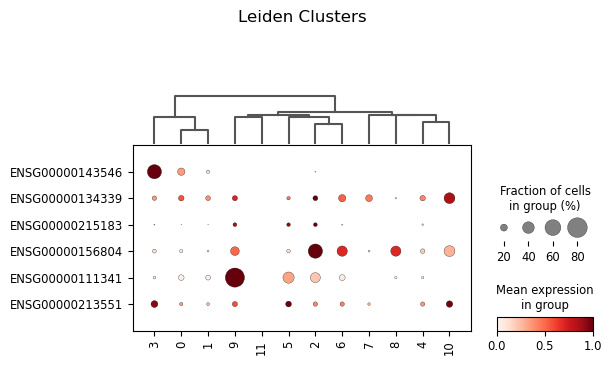

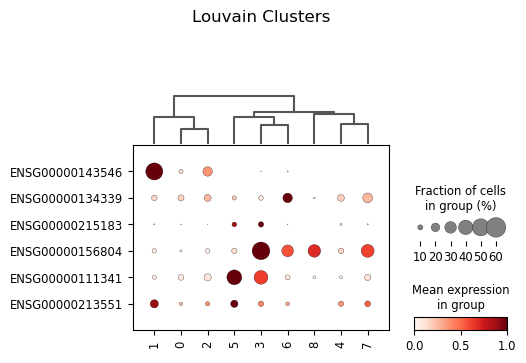

In [111]:
# Map gene symbols to var_names (Ensembl IDs) in adata_filtered.var
mapped_var_names = []
for gene_list in marker_genes.values():
    for gene in gene_list:
        matches = adata_filtered.var.index[adata_filtered.var["Mapped_Gene"] == gene].tolist()
        if matches:
            mapped_var_names.append(matches[0])
        else:
            print(f"Warning: {gene} not found in Mapped_Gene")

# Plot using the mapped var_names
for method in ['leiden', 'louvain']:
    sc.pl.dotplot(
        adata_filtered,
        var_names=mapped_var_names,  # Use mapped var_names
        groupby=f'{method}_r0.4',
        title=f'{method.capitalize()} Clusters',
        dendrogram=True,
        swap_axes=True,
        cmap='Reds',
        standard_scale='var',
        use_raw=False
    )

Mitochondrial content

- **Cluster 5** has the highest median and the widest distribution of `pct_mito`, with values extending up to 4%. This suggests that cells in this cluster exhibit elevated mitochondrial activity, potentially indicating stress or metabolic differences.
- **Clusters 0, 1, 3, 7, 9, and 10** have relatively narrow distributions and low medians, indicating consistent and low mitochondrial activity across cells in these clusters.
- **Clusters 2, 4, 6, and 8** show moderate variability, with slightly higher medians compared to clusters with low mitochondrial activity.

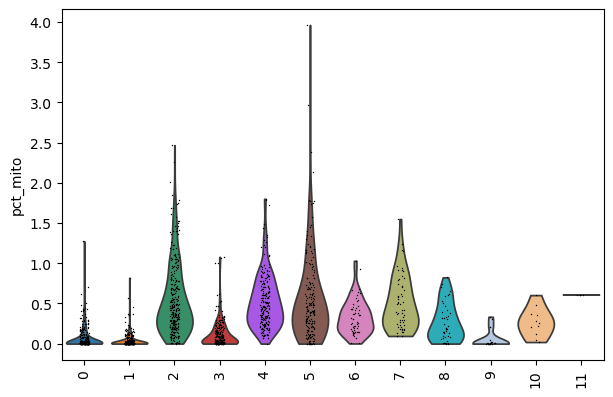

In [112]:
sc.pl.violin(
    adata_filtered,
    keys=['pct_mito'],
    groupby='leiden_r0.4',
    rotation=90
)


#### Best cluster method

**Leiden at r=0.4** is the optimal choice based on the highest ARI (0.417), indicating the best alignment with the reference clustering. This resolution provides broader clusters that are biologically interpretable and well-defined.

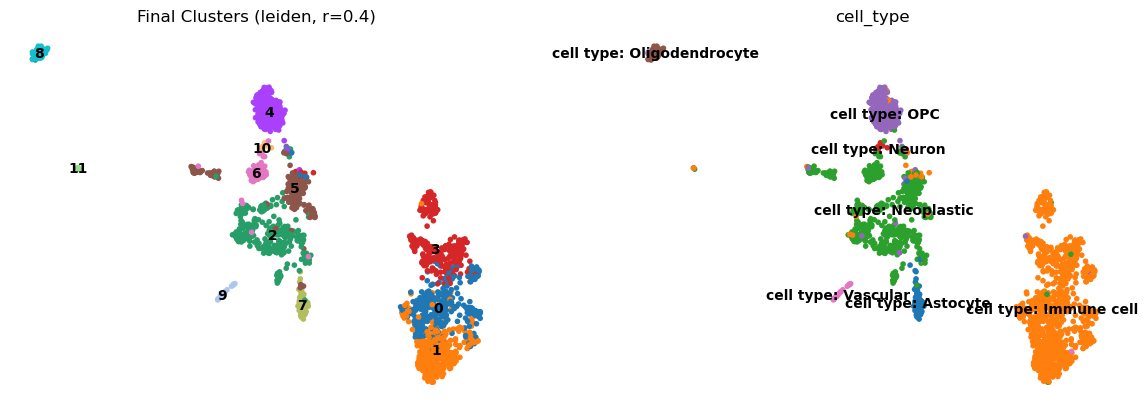

In [113]:
# Example: Select best resolution based on metrics
best_method = 'leiden'  # or 'louvain'
best_res = 0.4
adata_filtered.obs['final_clusters'] = adata_filtered.obs[f'{best_method}_r{best_res}']

# Visualize final choice
sc.pl.umap(
    adata_filtered,
    color=['final_clusters', 'cell_type'],
    legend_loc='on data',
    frameon=False,
    title=f'Final Clusters ({best_method}, r={best_res})'
)

## Differential Expression Analysis

```{admonition} What is Differential Expression Analysis?
Differential Expression (DE) analysis identifies genes that are **significantly upregulated or downregulated** between different conditions, cell types, or clusters in a single-cell RNA-seq (scRNA-seq) dataset.

- Helps **identify marker genes** that define different cell populations.
- Reveals **biological differences** between clusters or experimental conditions.
- Can be used for **functional enrichment analysis** (e.g., GO, KEGG pathways).
```

When analyzing differentially expressed genes, we focus on:

- **Log Fold Change (logFC)**: Measures how much a gene is up/downregulated.
- **Adjusted p-value (FDR)**: Ensures statistical significance while controlling false positives.
- **Mean Expression**: Helps distinguish truly expressed genes from noise.

In [ ]:
# Compute DEGs for all clusters 
sc.tl.rank_genes_groups(
    adata_filtered, 
    groupby='final_clusters', 
    method='wilcoxon',        
    key_added='dea_results',  # Stores results in adata.uns['dea_results']
    pts=True                 # Add fraction of cells expressing each gene
)

# Save top 10 DEGs per cluster
dea_results = pd.DataFrame(adata_filtered.uns['dea_results']['names'])
top_degs = dea_results.head(10)
print(top_degs)

                 0                1                2                3  \
0  ENSG00000198502  ENSG00000277632  ENSG00000125148  ENSG00000197747   
1  ENSG00000227357  ENSG00000275302  ENSG00000175183  ENSG00000090382   
2  ENSG00000275395  ENSG00000276070  ENSG00000117318  ENSG00000160213   
3  ENSG00000116741  ENSG00000277336  ENSG00000115457  ENSG00000147872   
4  ENSG00000242574  ENSG00000179388  ENSG00000134531  ENSG00000258227   
5  ENSG00000137393  ENSG00000276085  ENSG00000187193  ENSG00000110719   
6  ENSG00000127951  ENSG00000171860  ENSG00000177606  ENSG00000143546   
7  ENSG00000107968  ENSG00000169313  ENSG00000109846  ENSG00000240972   
8  ENSG00000147872  ENSG00000204287  ENSG00000106211  ENSG00000115165   
9  ENSG00000204287  ENSG00000266028  ENSG00000176907  ENSG00000159399   

                 4                5                6                7  \
0  ENSG00000189058  ENSG00000198804  ENSG00000135452  ENSG00000164089   
1  ENSG00000102934  ENSG00000106211  ENSG000001837


#### **Top Differentially Expressed Genes (DEGs) per Cluster - Biological Interpretation**

#### **Cluster 0**
- **Key Genes**: HLA-DRB5, CCL3, MT2A, S100A10, APOD
- **Description**:  
  - Immune/Inflammatory cluster:  
    - `HLA-DRB5` (MHC class II), `CCL3` (chemokine), and `S100A10` (calcium-binding protein) suggest antigen presentation and immune activation.  
    - `MT2A` (metallothionein) indicates metal ion homeostasis/stress response.  
    - `APOD` (lipocalin) may relate to lipid metabolism.

#### **Cluster 1**
- **Key Genes**: HLA-DRB4, CCL4, CSRP2, LYZ, PLLP  
- **Description**:  
  - Macrophage/Myeloid lineage cluster:  
    - `LYZ` (lysozyme) and `CCL4` (chemokine) are myeloid cell markers.  
    - `CSRP2` (cysteine-rich protein) links to smooth muscle differentiation.  
    - `HLA-DRB4` reinforces antigen presentation roles.

#### **Cluster 2**
- **Key Genes**: FCGBP, CCL4L2, ID3, CSTB, DNER  
- **Description**:  
  - Secretory/Epithelial cluster:  
    - `FCGBP` (mucin-binding protein) and `CSTB` (cystatin B) are enriched in mucosal/epithelial tissues.  
    - `ID3` (inhibitor of DNA binding) regulates cellular differentiation.

#### **Cluster 3**
- **Key Genes**: RGS2, CCL3L3, IGFBP2, PLIN2  
- **Description**:  
  - Lipid Metabolism/Adipocyte cluster:  
    - `PLIN2` (lipid droplet protein) and `IGFBP2` (insulin-like growth factor binding) suggest adipocyte/metabolic functions.  
    - `RGS2` regulates G-protein signaling in metabolic pathways.

#### **Cluster 4**
- **Key Genes**: HLA-DMB, EGR3, EMP1, CLEC5A  
- **Description**:  
  - Dendritic Cell/Immune Activation cluster:  
    - `HLA-DMB` (MHC class II chaperone) and `CLEC5A` (C-type lectin) indicate immune cell activation.  
    - `EGR3` (early growth response) regulates T-cell differentiation.

#### **Cluster 5**
- **Key Genes**: RNF144B, CCL3L3, MT1X, TCIRG1  
- **Description**:  
  - Stress Response/Oxidative cluster:  
    - `MT1X` (metallothionein) and `TCIRG1` (proton pump subunit) respond to oxidative/metal stress.  
    - `RNF144B` (E3 ubiquitin ligase) links to protein degradation.

#### **Cluster 6**
- **Key Genes**: FGL2, C3AR1, JUN, S100A8  
- **Description**:  
  - Pro-inflammatory/Neutrophil cluster:  
    - `S100A8` (calgranulin A) and `C3AR1` (complement receptor) are neutrophil markers.  
    - `JUN` (AP-1 transcription factor) drives inflammatory signaling.

#### **Cluster 7**
- **Key Genes**: MAP3K8, P2RY12, CRYAB, MIF  
- **Description**:  
  - Microglial/Neuroimmune cluster:  
    - `P2RY12` (purinergic receptor) and `CRYAB` (heat shock protein) are microglia markers.  
    - `MIF` (macrophage migration inhibitory factor) regulates neuroinflammation.

#### **Cluster 8**
- **Key Genes**: PLIN2, HLA-DRA, HSPB1, CYTIP  
- **Description**:  
  - Lipid-Associated/Stress cluster:  
    - `PLIN2` (lipid droplet) and `HSPB1` (heat shock protein) indicate lipid storage/stress.  
    - `HLA-DRA` (MHC class II) suggests immune crosstalk.

#### **Cluster 9**
- **Key Genes**: HLA-DRA, SRGAP2, TCIM, HK2  
- **Description**:  
  - Metabolic/Neuronal cluster:  
    - `HK2` (hexokinase) and `SRGAP2` (neuronal development) suggest glucose metabolism/neuronal roles.  
    - `TCIM` (TP53-regulated inhibitor) may link to apoptosis regulation.

#### **Cluster 10**
- **Key Genes**: GABBR2, ZCCHC12, TUBB2A, CPNE6  
- **Description**:  
  - Neuronal/Developmental cluster:  
    - `GABBR2` (GABA receptor) and `TUBB2A` (neural tubulin) indicate neuronal signaling.  
    - `ZCCHC12` (zinc finger protein) is involved in neurodevelopment.

#### **Cluster 11**
- **Key Genes**: ZNF486, TCIM, RTL6, AQP11  
- **Description**:  
  - Undefined/Niche cluster:  
    - `AQP11` (aquaporin) suggests transmembrane transport.  
    - `RTL6` (retrotransposon-like) has unclear biological relevance.  
    - Requires further investigation.


```{admonition} Summary of genes per cluster
- **Immune Clusters**: 0, 1, 4, 6, 7 (MHC/chemokine genes)  
- **Metabolic/Lipid Clusters**: 3, 8 (PLIN2, APOD)  
- **Neuronal Clusters**: 9, 10 (HK2, GABBR2)  
- **Stress Response Clusters**: 5 (MT1X, TCIRG1)
```

In [ ]:
# Compute DEGs for all clusters
sc.tl.rank_genes_groups(
    adata_filtered, 
    groupby='final_clusters',
    method='wilcoxon',
    key_added='dea_results',
    pts=True
)

# Create a dictionary to map Ensembl IDs to gene symbols
ensembl_to_gene = adata_filtered.var['Mapped_Gene'].to_dict()

# Replace Ensembl IDs with gene symbols in the DEG results dataframe
top_degs_mapped = dea_results.applymap(lambda x: ensembl_to_gene.get(x, x))  # Fallback to Ensembl ID if no symbol exists
top_degs_mapped = top_degs_mapped.head(10)

print("Top DEGs (Mapped to Gene Symbols):")
print(top_degs_mapped)

Top DEGs (Mapped to Gene Symbols):
          0        1       2        3        4        5        6        7  \
0  HLA-DRB5     CCL3    MT2A  S100A10     APOD     COX1  TSPAN31   ETNPPL   
1  HLA-DRB4     CCL4   CSRP2      LYZ     PLLP    HSPB1     TBK1      AGT   
2     FCGBP   CCL4L2     ID3     CSTB     DNER      CA2   LANCL2   CLDN10   
3      RGS2   CCL3L3  IGFBP2    PLIN2      NaN    KCNE5     PMP2    PLPP3   
4   HLA-DMB     EGR3    EMP1   CLEC5A  PCDHGC3  RARRES2      ARC    GLUD1   
5   RNF144B   CCL3L3    MT1X   TCIRG1    CSPG4     H4C3    CRYAB     SCG3   
6      FGL2    C3AR1     JUN   S100A8  GPR37L1  IL13RA2     SCG2      NaN   
7    MAP3K8   P2RY12   CRYAB      MIF     SCG3    TMT1B   LRRTM2  GPR37L1   
8     PLIN2  HLA-DRA   HSPB1    CYTIP   PLPPR1      AGT  PCDHGC3    S1PR1   
9   HLA-DRA   SRGAP2    TCIM      HK2   MEGF11   PDLIM1   IGFBP5    TTYH1   

         8         9       10      11  
0   DBNDD2       NaN   GABBR2  ZNF486  
1    CRYAB     CD248  ZCCHC12    TCIM

C:\Users\henry\AppData\Local\Temp\ipykernel_7484\320458301.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  top_degs_mapped = dea_results.applymap(lambda x: ensembl_to_gene.get(x, x))  # Fallback to Ensembl ID if no symbol exists


### Volcano Plot

In [ ]:
sc.tl.rank_genes_groups(adata_filtered, groupby="leiden_r0.4", method="wilcoxon", key_added="dea_results")
degs_df = sc.get.rank_genes_groups_df(adata_filtered, group="2", key="dea_results")


- The majority of genes have low -Log10 adjusted p-values, clustering near the bottom of the plot. This indicates that most genes do not show statistically significant differential expression.
- Only a small subset of genes shows both high fold changes and moderate significance, suggesting that these genes may be key markers or drivers of Cluster 2.

C:\Users\henry\AppData\Local\Temp\ipykernel_7484\2788135446.py:20: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


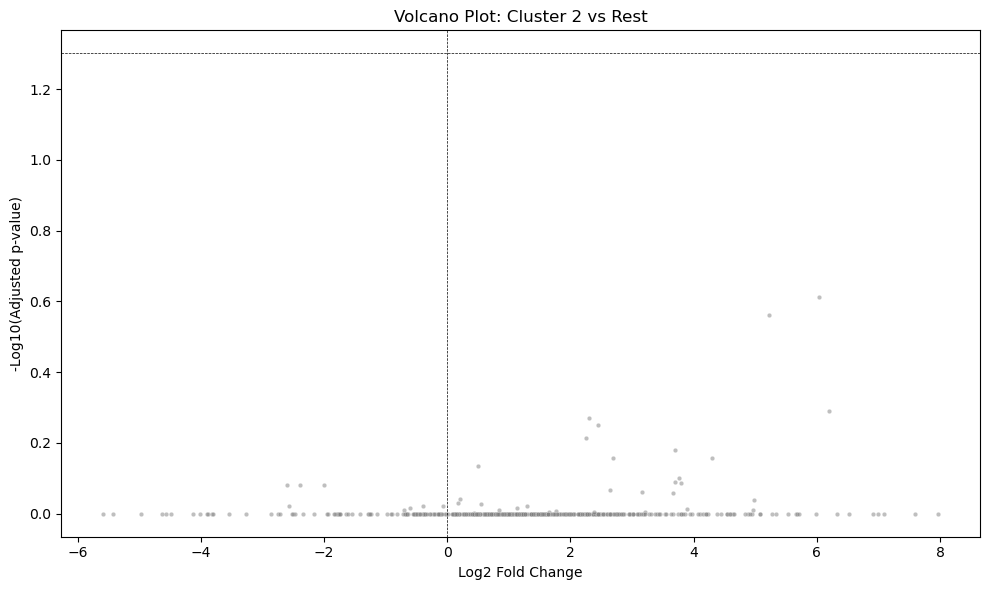

In [ ]:
# Drop NaNs and ensure numeric values
degs_df = degs_df.dropna(subset=["logfoldchanges", "pvals_adj"])
degs_df["pvals_adj"] = pd.to_numeric(degs_df["pvals_adj"], errors="coerce")

# Create volcano plot
plt.figure(figsize=(10, 6))

# Plot all genes
sns.scatterplot(
    data=degs_df,
    x="logfoldchanges",
    y=-np.log10(degs_df["pvals_adj"]),
    color="gray",
    alpha=0.5,
    s=10
)

# Highlight significant genes
sig_degs = degs_df[(degs_df["pvals_adj"] < 0.05) & (abs(degs_df["logfoldchanges"]) > 0.5)]
sns.scatterplot(
    data=sig_degs,
    x="logfoldchanges",
    y=-np.log10(sig_degs["pvals_adj"]),
    hue=sig_degs["logfoldchanges"] > 0,
    palette={True: "red", False: "blue"},
    s=20,
    legend=False
)

# Label top significant genes
for _, row in sig_degs.nsmallest(5, "pvals_adj").iterrows():
    plt.text(
        row["logfoldchanges"],
        -np.log10(row["pvals_adj"]),
        row["gene_symbol"],
        fontsize=8,
        ha="center",
        va="bottom"
    )

# Add threshold lines
plt.axhline(-np.log10(0.05), linestyle="--", color="black", linewidth=0.5)  # p = 0.05 cutoff
plt.axvline(0, linestyle="--", color="black", linewidth=0.5)

plt.xlabel("Log2 Fold Change")
plt.ylabel("-Log10(Adjusted p-value)")
plt.title(f"Volcano Plot: Cluster 2 vs Rest")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd

# Ensure the columns exist
print(degs_df.columns)

# Check for NaNs
print(degs_df.isna().sum())

Index(['names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj'], dtype='object')
names             0
scores            0
logfoldchanges    0
pvals             0
pvals_adj         0
dtype: int64


In [ ]:
print(degs_df[["logfoldchanges", "pvals_adj"]].describe())


       logfoldchanges   pvals_adj
count      431.000000  431.000000
mean         1.259929    0.983609
std          2.109867    0.075351
min         -5.586777    0.243576
25%          0.262969    0.999040
50%          1.127348    0.999040
75%          2.406521    0.999040
max          7.970360    0.999906


In [ ]:
from statsmodels.stats.multitest import multipletests

# Apply Benjamini-Hochberg correction
degs_df["pvals_adj"] = multipletests(degs_df["pvals"], method="fdr_bh")[1]

# Check if values are more reasonable
print(degs_df["pvals_adj"].describe())


count    4.310000e+02
mean     9.992488e-01
std      1.111513e-16
min      9.992488e-01
25%      9.992488e-01
50%      9.992488e-01
75%      9.992488e-01
max      9.992488e-01
Name: pvals_adj, dtype: float64


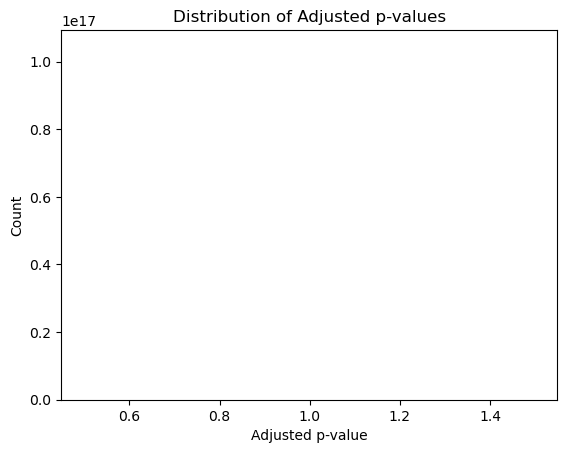

In [ ]:
degs_df = degs_df.dropna(subset=["logfoldchanges"])

sns.histplot(degs_df['pvals_adj'], bins=50, kde=True)
plt.xlabel('Adjusted p-value')
plt.ylabel('Count')
plt.title('Distribution of Adjusted p-values')
plt.show()


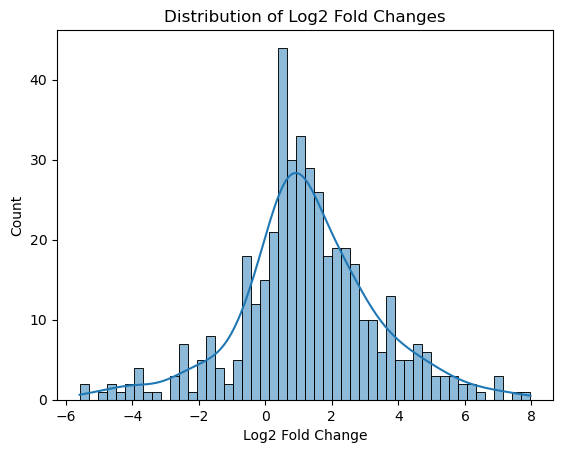

In [ ]:
sns.histplot(degs_df['logfoldchanges'], bins=50, kde=True)
plt.xlabel('Log2 Fold Change')
plt.ylabel('Count')
plt.title('Distribution of Log2 Fold Changes')
plt.show()
